<a href="https://colab.research.google.com/github/Jasper-Hewitt/final_project_elections/blob/main/df_combined_trad_jiaboroberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Init

In [1]:
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wh

In [2]:
#import our model from huggingface
number_classes = 2
model_tokenizer = "hfl/chinese-roberta-wwm-ext"

if number_classes == 2:
    model_classifier = "Jiabo/Roberta_Chinese_sentiment"
else:
    model_classifier = "owen198/weibo-wmmbert-6"


In [3]:
model_classifier

'Jiabo/Roberta_Chinese_sentiment'

# 1. load and clean data

In [4]:
! wget -nc https://github.com/Jasper-Hewitt/final_project_elections/blob/main/data/test/df_combined_trad.xlsx?raw=true

--2023-01-05 04:25:26--  https://github.com/Jasper-Hewitt/final_project_elections/blob/main/data/test/df_combined_trad.xlsx?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Jasper-Hewitt/final_project_elections/raw/main/data/test/df_combined_trad.xlsx [following]
--2023-01-05 04:25:27--  https://github.com/Jasper-Hewitt/final_project_elections/raw/main/data/test/df_combined_trad.xlsx
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Jasper-Hewitt/final_project_elections/main/data/test/df_combined_trad.xlsx [following]
--2023-01-05 04:25:27--  https://raw.githubusercontent.com/Jasper-Hewitt/final_project_elections/main/data/test/df_combined_trad.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.

In [5]:
ici_map_dict = dict()

if number_classes == 6:

    ici_map_dict['angry']=0
    ici_map_dict['anger']=0
    ici_map_dict['positive']=1
    ici_map_dict['posiitive']=1
    ici_map_dict['happy']=1
    ici_map_dict['neutral']=2
    ici_map_dict['neural']=2
    ici_map_dict['surprise']=3
    ici_map_dict['suprise']=3
    ici_map_dict['sad']=4
    ici_map_dict['negative']=4
    ici_map_dict['fear']=5
else:
    ici_map_dict['positive']=1 #pos
#    ici_map_dict['posiitive']=1 #pos
#    ici_map_dict['neutral']=3 #ignore
#    ici_map_dict['surprise']=3 #ignore
    ici_map_dict['negative']=0 #neg
 

len(ici_map_dict)

2

In [6]:
import pandas as pd

In [7]:
testing_pd = pd.read_excel('/content/df_combined_trad.xlsx?raw=true')

testing_pd = testing_pd[['text', 'cya_check_3']]
testing_pd = testing_pd.rename(columns={'cya_check_3':'label'})
testing_pd = testing_pd[(testing_pd['label'] == 'negative') | (testing_pd['label'] == 'positive')]


# align labels
# testing_pd['label'].unique()
testing_pd['label'] = testing_pd['label'].str.lower()
testing_pd['label'] = testing_pd['label'].str.split(' ', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].str.split(',', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].map(ici_map_dict).astype('int')

testing_pd.shape

(265, 2)

In [8]:
#dirty data
testing_pd

,text,label
0,【石舫亙代蔣萬安向黃國樑資深黨員致意 喊萬華不是破口】國民黨台北市長候選人蔣萬安的太太石舫亙...,1
1,【身體力行迎戰少子化問題 蔣萬安妻子傳已懷第3胎】長期關心台灣少子化問題，8月25日也曾發布...,1
2,【周玉蔻狂“助選”效果超大？台北人街頭民調最新結果曝光】資深媒體人周玉蔻近期大力支持民進黨台...,0
3,蔣萬安稱，他是“正藍軍”，呼籲藍營團結支持。​,1
5,【日學者預測台北市長不是他當選 陳時中：我當選可跟中心無縫接軌】日本學者預測，這次台北市長選...,1
...,...,...
392,【藍綠互打政二代 港媒預言最慘結局與最後贏家】國民黨台北市議員徐巧芯日前公佈民進黨台北市長參...,0
393,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民<br...,0
396,【周玉蔻怎能霸占黃金時段？郭正亮爆：被“有分量”金主標下】資深媒體人周玉蔻日前攻擊國民黨台北...,0
397,額？ ？ ？這是蔣萬安的競選團隊？ ？ ？,0


In [9]:
#we can consider not deleting the titles. This will be up to the ICI project group to decide
testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]

# TODO: we should remove non-Chinese characters in 'text column'
import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'

#we have to find a way to delete the entire <span> tag. some posts will end up with only 2 or 3 characters after that. We can drop them. 



testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)

if number_classes == 6:
    pass
else:
    testing_pd = testing_pd[testing_pd['label'] != 3]

testing_pd = testing_pd.dropna().reset_index(drop=True)

<ipython-input-9-e80b1016d358>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
<ipython-input-9-e80b1016d358>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
<ipython-input-9-e80b1016d358>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [10]:
#clean data
testing_pd

,text,label
0,國民黨台北市長候選人蔣萬安的太太石舫亙上週起開始幫忙分攤市場掃街行程，今天上午前往黃國樑資深...,1
1,長期關心台灣少子化問題，8月25日也曾發布“育兒生養政策”的國民黨台北市長候選人蔣萬安，傳出...,1
2,資深媒體人周玉蔻近期大力支持民進黨台北市長候選人陳時中，為此多次向國民黨候選人蔣萬安開砲，還...,0
3,蔣萬安稱，他是“正藍軍”，呼籲藍營團結支持。​,1
4,日本學者預測，這次台北市長選舉，國民黨候選人蔣萬安可能當選；民進黨台北市長候選人陳時中今受訪...,1
...,...,...
218,說什麼蔣經國不是蔣介石親生的，蔣介石沒有後，純屬扯淡，蔣友柏和蔣介石很像好嗎,0
219,國民黨台北市議員徐巧芯日前公佈民進黨台北市長參選人陳時中競選辦公室分機通訊錄，名單中竟有許多...,0
220,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民變色媒...,0
221,資深媒體人周玉蔻日前攻擊國民黨台北市長候選人蔣萬安，指其父緋聞女主角是張淑娟，還在遭按鈴申告...,0


In [11]:
#delete empty rows
testing_pd = testing_pd[testing_pd['text'].str.len()>2]   
testing_pd = testing_pd[['text', 'label']]
testing_pd = testing_pd.reset_index(drop=True)
testing_pd

,text,label
0,國民黨台北市長候選人蔣萬安的太太石舫亙上週起開始幫忙分攤市場掃街行程，今天上午前往黃國樑資深...,1
1,長期關心台灣少子化問題，8月25日也曾發布“育兒生養政策”的國民黨台北市長候選人蔣萬安，傳出...,1
2,資深媒體人周玉蔻近期大力支持民進黨台北市長候選人陳時中，為此多次向國民黨候選人蔣萬安開砲，還...,0
3,蔣萬安稱，他是“正藍軍”，呼籲藍營團結支持。​,1
4,日本學者預測，這次台北市長選舉，國民黨候選人蔣萬安可能當選；民進黨台北市長候選人陳時中今受訪...,1
...,...,...
218,說什麼蔣經國不是蔣介石親生的，蔣介石沒有後，純屬扯淡，蔣友柏和蔣介石很像好嗎,0
219,國民黨台北市議員徐巧芯日前公佈民進黨台北市長參選人陳時中競選辦公室分機通訊錄，名單中竟有許多...,0
220,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民變色媒...,0
221,資深媒體人周玉蔻日前攻擊國民黨台北市長候選人蔣萬安，指其父緋聞女主角是張淑娟，還在遭按鈴申告...,0


In [12]:
#upsize minority class (positive). You can consider turning this cell off. With the current data (df_sample.xlsx) this will lead to a 0.840 accuracy. 
# if number_classes == 2:
#     from sklearn.utils import resample

#     df_majority = testing_pd[testing_pd.label==0]
#     df_minority = testing_pd[testing_pd.label==1]

#     # Upsample minority class
#     df_minority_upsampled = resample(df_minority, 
#                                     replace=True,     # sample with replacement
#                                     n_samples=df_majority.shape[0],    # to match majority class
#                                     random_state=42) # reproducible results

#     # Combine majority class with upsampled minority class
#     testing_pd = pd.concat([df_majority, df_minority_upsampled])


In [13]:
num_label = len(testing_pd['label'].unique())
num_label

2

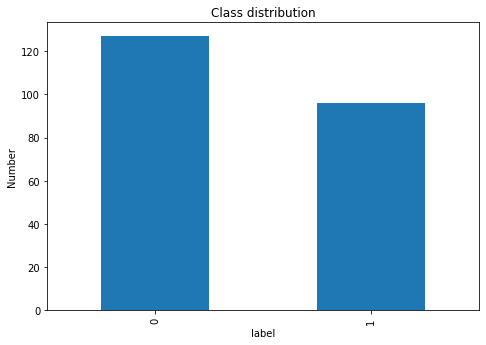

In [14]:
import matplotlib.pyplot as plt

counts = testing_pd.groupby("label").size()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

# Create a bar plot
counts.plot(kind="bar")

# Show the plot
ax.set_ylabel('Classes')
ax.set_ylabel('Number')
ax.set_title('Class distribution')
plt.show()

## 1-2 Tokenization

In [15]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [16]:
from transformers import AutoTokenizer

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [18]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [19]:
full_test_dataset = tokenized_datasets["test"]

# 2. Testing

In [20]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=num_label)

Downloading:   0%|          | 0.00/958 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/409M [00:00<?, ?B/s]

In [21]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-21-e1ee7db0da93>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


## 2-1 Get Accuracy

In [22]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

In [23]:
import numpy as np

# trainer.evaluate()

In [24]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 223
  Batch size = 8


In [25]:
#get test accuracy
pred.metrics

{'test_loss': 0.2946646511554718,
 'test_accuracy': 0.8968609865470852,
 'test_runtime': 9.8574,
 'test_samples_per_second': 22.623,
 'test_steps_per_second': 2.841}

In [26]:
pred

PredictionOutput(predictions=array([[-1.8687189 ,  2.106629  ],
       [-2.5256941 ,  3.0817819 ],
       [ 1.4336312 , -1.8524781 ],
       [-1.1046354 ,  1.2862039 ],
       [-2.4588842 ,  3.0137143 ],
       [-0.09892274, -0.6510862 ],
       [-2.164797  ,  2.6384583 ],
       [ 3.0277512 , -2.8552308 ],
       [ 2.276233  , -2.3161995 ],
       [ 3.084352  , -2.951609  ],
       [ 1.1476465 , -1.6926135 ],
       [ 1.3176763 , -1.6863769 ],
       [ 3.1584492 , -2.9794006 ],
       [ 2.2633038 , -2.2834487 ],
       [ 0.7109042 , -1.1326823 ],
       [ 2.9427512 , -2.8103812 ],
       [ 3.2350106 , -3.2907755 ],
       [ 1.3756627 , -1.9147204 ],
       [-0.72820455,  0.9344733 ],
       [ 1.9174478 , -2.0238848 ],
       [ 1.051956  , -1.5903664 ],
       [ 0.7656495 , -1.4291121 ],
       [ 1.4456636 , -1.834398  ],
       [-1.3511827 ,  1.5205076 ],
       [ 1.535421  , -1.92813   ],
       [ 3.245253  , -3.110846  ],
       [ 1.8340727 , -2.085805  ],
       [ 2.4025555 , -2.37

In [27]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0])

In [28]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

# 3. Analyse predictions

In [29]:

#look at all the results
testing_pd

,text,label,pred
0,國民黨台北市長候選人蔣萬安的太太石舫亙上週起開始幫忙分攤市場掃街行程，今天上午前往黃國樑資深...,1,1
1,長期關心台灣少子化問題，8月25日也曾發布“育兒生養政策”的國民黨台北市長候選人蔣萬安，傳出...,1,1
2,資深媒體人周玉蔻近期大力支持民進黨台北市長候選人陳時中，為此多次向國民黨候選人蔣萬安開砲，還...,0,0
3,蔣萬安稱，他是“正藍軍”，呼籲藍營團結支持。​,1,1
4,日本學者預測，這次台北市長選舉，國民黨候選人蔣萬安可能當選；民進黨台北市長候選人陳時中今受訪...,1,1
...,...,...,...
218,說什麼蔣經國不是蔣介石親生的，蔣介石沒有後，純屬扯淡，蔣友柏和蔣介石很像好嗎,0,0
219,國民黨台北市議員徐巧芯日前公佈民進黨台北市長參選人陳時中競選辦公室分機通訊錄，名單中竟有許多...,0,0
220,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民變色媒...,0,1
221,資深媒體人周玉蔻日前攻擊國民黨台北市長候選人蔣萬安，指其父緋聞女主角是張淑娟，還在遭按鈴申告...,0,0


In [30]:
#see where BERT got it wrong. The count column stands for how many comma's the sentence has... In case we want to consider removing some sentences. 
mistakes_pd = testing_pd.loc[testing_pd['label'] != testing_pd['pred']]
mistakes_pd = (mistakes_pd.reset_index()
        .drop_duplicates(subset='index', keep='last')
        .set_index('index').sort_index())
mistakes_pd['count'] = mistakes_pd['text'].str.count('，')
mistakes_pd.sort_values(by="count")

,text,label,pred,count
index,,,,
95,#蔣萬安贏得台北市長選舉#趕緊開放自由行吧不想說了 ​,1,0,0
136,蔣介石的曾孫蔣萬安當選中國台北市市長!老蔣的後代也不過如此嘛，才當了一個台北市二把手!#台灣# ​,0,1,1
89,#蔣萬安贏得台北市長選舉#對台灣人不報希望，換湯不換藥。支持統一才是大事！​,0,1,1
28,周玉蔻放大招，找到蔣家後人稱不相信蔣萬安與蔣經國有血緣關係，願和蔣萬安做DNA對比 ​,0,1,2
5,全世界都在關注世界杯，只有我在關注台灣九合一選舉如果我在台北，我會支持黃珊珊，但大概率蔣萬安...,1,0,3
86,#蔣萬安贏得台北市長選舉#蔣萬安就更搞笑了，既要又要既當又立還軟骨頭只想蹭蔣經國又要和凱申公...,0,1,3
42,媒體人周玉蔻沉寂多時後，今（10）日正式複出廣播節目，首位嘉賓邀請網紅“四叉貓”。國民黨台北...,0,1,4
57,#鳳凰新聞#據台媒報導綠營名嘴周玉蔻近期猛打國民黨台北市長參選人蔣萬安，更拋出“驗DNA”議...,0,1,4
154,媒體人周玉蔻近期猛攻國民黨台北市長候選人蔣萬安家族，更公開高喊“我就是愛阿中！”國民黨台北市...,1,0,5


In [31]:
#see where BERT got it right
correct_pd = testing_pd.loc[testing_pd['label'] == testing_pd['pred']]
correct_pd = (correct_pd.reset_index()
        .drop_duplicates(subset='index', keep='last')
        .set_index('index').sort_index())
correct_pd['count'] = correct_pd['text'].str.count('，')
correct_pd.sort_values(by="count")

,text,label,pred,count
index,,,,
222,額？ ？ ？這是蔣萬安的競選團隊？ ？ ？,0,0,0
36,蔣萬安高呼：我是唯一最有能力打敗陳時中的人#海峽新幹線 #台海時刻#武統 L武力統一的微博...,1,1,0
37,蔣萬安批：民進黨是最大的詐騙集團 武統 L武力統一的微博視頻 ​,0,0,0
40,#陳時中被嗆踩著萬俱屍體過去# L海峽導報社的微博視頻 ​,0,0,0
48,蔻蔻撕蔣萬安蔣萬安到現在屁都不敢放辣雞 ​,0,0,0
...,...,...,...,...
167,爆周玉蔻與蔣萬安決裂原因，徐巧芯：她以前動不動找蔣萬安上節目 據台媒報導，台資深媒體人周玉蔻...,0,0,21
176,親綠媒體人周玉蔻近日爆料國民黨台北市長參選人蔣萬安的父親蔣孝嚴當年“晶華緋聞案”的細節，攪亂...,0,0,31
165,國民黨告陳時中瀆職 質疑其疫苗採購黑箱操作 中新網9月22日電 據台灣報導，國民黨認為參選台...,0,0,41


In [32]:
#correct_count_pd = correct_pd['text'].str.len()
#pd.DataFrame(correct_count_pd)